In [5]:
import requests
import logging
import datetime
import csv
import os

logging.basicConfig(level=logging.INFO)


def get_file(url: str, file: str) -> bool:
    r = requests.get(url, allow_redirects=True)
    if r.ok:
        logging.info(f"Request got valid response : {r.status_code}. Content sample : {r.content[:100]}")
        open(file, 'wb').write(r.content)
    else:
        logging.error(f"Request failed at path : {url}. Full content : {r.content}")
    return r.ok


def get_gouv_data_and_metadata(
        save_folder_path: str = "./data/raw",
        base_url: str = "https://files.data.gouv.fr/lcsqa/concentrations-de-polluants-atmospheriques-reglementes/temps-reel",
        file_prefix: str = "FR_E2",
        metadata_url: str = "https://www.data.gouv.fr/fr/datasets/donnees-temps-reel-de-mesure-des-concentrations-de-polluants-atmospheriques-reglementes-1/#/resources/eb87c56c-dea9-4377-a1e7-03ada59d3043"
) -> bool:
    today = datetime.date.today()
    start_date = datetime.date(2021, 1, 1)
    current_date = start_date

    metadata_file_name = "metadata.xls"
    metadata_full_url = metadata_url
    metadata_full_save_path = f"{save_folder_path}/{metadata_file_name}"

    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(metadata_full_save_path), exist_ok=True)

    metadata_full_save_path = f"{save_folder_path}/{metadata_file_name}"
    metadata_response_status = get_file(metadata_full_url, metadata_full_save_path)
    if not metadata_response_status:
        return False

    data_file_name = "data.csv"
    data_full_save_path = f"{save_folder_path}/{data_file_name}"
    with open(data_full_save_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Date", "Pollutant", "Value"])

        while current_date <= today:
            day = str(current_date.day).zfill(2)
            month = str(current_date.month).zfill(2)
            year = str(current_date.year)
            file_name = f"{file_prefix}_{year}-{month}-{day}.csv"
            full_url = f"{base_url}/{year}/{file_name}"
            full_save_path = f"{save_folder_path}/{file_name}"
            response_status = get_file(full_url, full_save_path)
            if not response_status:
                return False

            # Read data from the downloaded file and write it to the combined CSV file
            with open(full_save_path, 'r') as datafile:
                reader = csv.reader(datafile)
                next(reader)  # Skip the header row
                for row in reader:
                    if len(row) >= 2:  # Check if the row has at least two elements
                        writer.writerow([f"{year}-{month}-{day}", row[0], row[1]])

            current_date += datetime.timedelta(days=1)

    return True

get_gouv_data_and_metadata()

INFO:root:Request got valid response : 200. Content sample : b'<!DOCTYPE html><html lang="fr" data-fr-scheme="light" data-fr-theme="light">\n\n<head>\n    \n    \n    \n'
INFO:root:Request got valid response : 200. Content sample : b"\xef\xbb\xbfDate de d\xc3\xa9but;Date de fin;Organisme;code zas;Zas;code site;nom site;type d'implantation;Polluant"
INFO:root:Request got valid response : 200. Content sample : b"\xef\xbb\xbfDate de d\xc3\xa9but;Date de fin;Organisme;code zas;Zas;code site;nom site;type d'implantation;Polluant"
INFO:root:Request got valid response : 200. Content sample : b"\xef\xbb\xbfDate de d\xc3\xa9but;Date de fin;Organisme;code zas;Zas;code site;nom site;type d'implantation;Polluant"
INFO:root:Request got valid response : 200. Content sample : b"\xef\xbb\xbfDate de d\xc3\xa9but;Date de fin;Organisme;code zas;Zas;code site;nom site;type d'implantation;Polluant"
INFO:root:Request got valid response : 200. Content sample : b"\xef\xbb\xbfDate de d\xc3\xa9but;Date de fin;O

True

In [7]:
import pandas as pd
import glob

# Get a list of all CSV files in the directory
csv_files = glob.glob('./data/raw/*.csv')

# Create an empty DataFrame to store the merged data
merged_df = pd.DataFrame()

# Iterate over each CSV file and append its contents to the merged DataFrame
for file in csv_files:
    df = pd.read_csv(file)
    merged_df = pd.concat([merged_df, df], ignore_index=True)

# Save the merged DataFrame to a new CSV file
merged_df.to_csv('./data/merged_data.csv', index=False)


In [11]:
import pandas as pd
import os

# Définir la taille du chunk
chunk_size = 10000

# Chemin vers le fichier CSV
file_path = './data/merged_data.csv'

# Lire le fichier CSV en chunks
for chunk in pd.read_csv(file_path, delimiter=';', chunksize=chunk_size):
    # Pour chaque valeur unique dans la colonne 'Polluant', créer un sous-dataset
    for polluant in chunk['Polluant'].unique():
        subset = chunk[chunk['Polluant'] == polluant]

        # Définir le chemin du fichier de sortie
        output_file = f'./data/subsets/subset_{polluant}.csv'

        # Écrire le subset dans un fichier
        # Le mode 'a' est utilisé pour ajouter au fichier si celui-ci existe déjà
        # 'header=False' n'écrit pas l'en-tête si le fichier existe déjà
        if not os.path.exists(output_file):
            subset.to_csv(output_file, index=False, mode='w', header=True)
        else:
            subset.to_csv(output_file, index=False, mode='a', header=False)


In [67]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('./data/subsets/subset_NO2.csv', delimiter=',')

df.head()

,Date de début,Date de fin,Organisme,code zas,Zas,code site,nom site,type d'implantation,Polluant,type d'influence,...,procédure de mesure,type de valeur,valeur,valeur brute,unité de mesure,taux de saisie,couverture temporelle,couverture de données,code qualité,validité
0,2021/01/01 00:00:00,2021/01/01 01:00:00,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,NO2,Fond,...,Auto NO2_NOx Conf meth CHIMILU,moyenne horaire validée,9.0,9.000,µg-m3,NaN,NaN,NaN,A,1
1,2021/01/01 01:00:00,2021/01/01 02:00:00,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,NO2,Fond,...,Auto NO2_NOx Conf meth CHIMILU,moyenne horaire validée,7.6,7.600,µg-m3,NaN,NaN,NaN,A,1
2,2021/01/01 02:00:00,2021/01/01 03:00:00,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,NO2,Fond,...,Auto NO2_NOx Conf meth CHIMILU,moyenne horaire validée,7.4,7.425,µg-m3,NaN,NaN,NaN,A,1
3,2021/01/01 03:00:00,2021/01/01 04:00:00,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,NO2,Fond,...,Auto NO2_NOx Conf meth CHIMILU,moyenne horaire validée,7.7,7.650,µg-m3,NaN,NaN,NaN,A,1
4,2021/01/01 04:00:00,2021/01/01 05:00:00,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,NO2,Fond,...,Auto NO2_NOx Conf meth CHIMILU,moyenne horaire validée,8.0,7.975,µg-m3,NaN,NaN,NaN,A,1


In [68]:
df.shape

(9845037, 23)

# Valeurs manquantes et suppression des features inutiles

<Axes: >

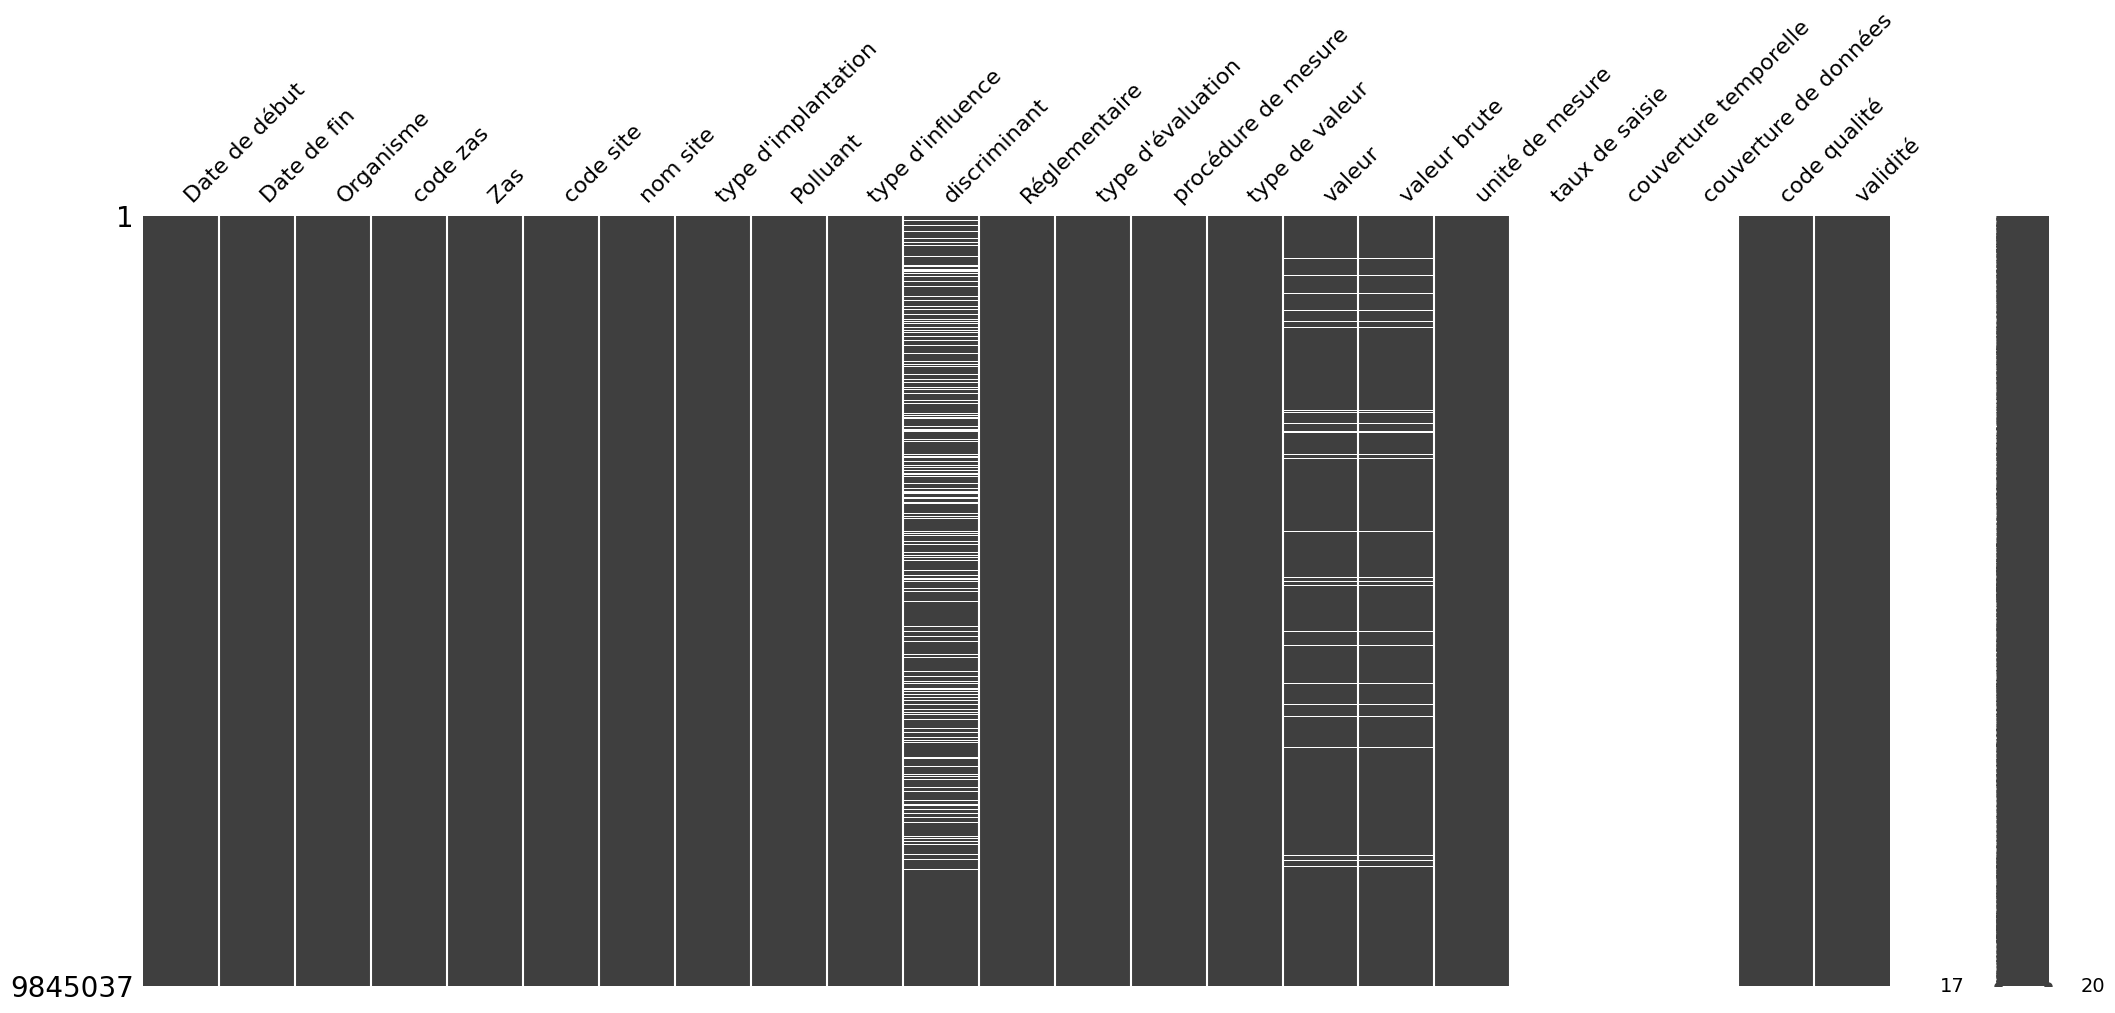

In [69]:
import missingno as msno
# Matrice des données manquantes avec missingno
msno.matrix(df)

In [70]:
# Calculer le nombre de valeurs manquantes pour chaque colonne et filtrer celles avec des valeurs manquantes
num_missing_by_col = df.isnull().sum()
num_missing_by_col = num_missing_by_col[num_missing_by_col > 0].sort_values(ascending=False)

# Afficher le nombre de valeurs manquantes pour chaque colonne concernée
print(num_missing_by_col)


taux de saisie           9845037
couverture temporelle    9845037
couverture de données    9845037
discriminant             1841704
valeur                    316877
valeur brute              316877
dtype: int64


On remarque que les colonnes "Taux de saisie", "couverture temporelle" et "couverture de données" ne comportent que des valeurs manquantes donc on peut les supprimer pour supprimer le bruit.

In [71]:
df = df.drop(columns=['taux de saisie', 'couverture temporelle', 'couverture de données'])
df.shape 

(9845037, 20)

On peut par ailleurs supprimer la colonne "Valeur" qui représente les valeurs de pollution arrondies au dixième de la colonne valeur brute.

In [72]:
df = df.drop(columns=['valeur'])

Par ailleurs on peut supprimer les lignes ne contenant aucune information sur le taux de pollution à savoir les lignes pour lesquelles valeur brute = NAN.

In [73]:
df = df.dropna(subset=['valeur brute'])

In [74]:
df.head()

,Date de début,Date de fin,Organisme,code zas,Zas,code site,nom site,type d'implantation,Polluant,type d'influence,discriminant,Réglementaire,type d'évaluation,procédure de mesure,type de valeur,valeur brute,unité de mesure,code qualité,validité
0,2021/01/01 00:00:00,2021/01/01 01:00:00,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,NO2,Fond,B,Oui,mesures fixes,Auto NO2_NOx Conf meth CHIMILU,moyenne horaire validée,9.000,µg-m3,A,1
1,2021/01/01 01:00:00,2021/01/01 02:00:00,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,NO2,Fond,B,Oui,mesures fixes,Auto NO2_NOx Conf meth CHIMILU,moyenne horaire validée,7.600,µg-m3,A,1
2,2021/01/01 02:00:00,2021/01/01 03:00:00,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,NO2,Fond,B,Oui,mesures fixes,Auto NO2_NOx Conf meth CHIMILU,moyenne horaire validée,7.425,µg-m3,A,1
3,2021/01/01 03:00:00,2021/01/01 04:00:00,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,NO2,Fond,B,Oui,mesures fixes,Auto NO2_NOx Conf meth CHIMILU,moyenne horaire validée,7.650,µg-m3,A,1
4,2021/01/01 04:00:00,2021/01/01 05:00:00,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,NO2,Fond,B,Oui,mesures fixes,Auto NO2_NOx Conf meth CHIMILU,moyenne horaire validée,7.975,µg-m3,A,1


In [75]:
unique_values = df.apply(lambda x: x.unique())
print(unique_values)

Date de début          [2021/01/01 00:00:00, 2021/01/01 01:00:00, 202...
Date de fin            [2021/01/01 01:00:00, 2021/01/01 02:00:00, 202...
Organisme              [ATMO GRAND EST, ATMO SUD, AIRPARIF, ATMO NORM...
code zas               [FR44ZAG02, FR44ZRE01, FR93ZRE01, FR93ZAG01, F...
Zas                    [ZAG METZ, ZR GRAND-EST, ZR PROVENCE-ALPES-COT...
code site              [FR01011, FR01012, FR01016, FR01018, FR01019, ...
nom site               [Metz-Centre, Metz-Borny, Atton, Scy-Chazelles...
type d'implantation    [Urbaine, Rurale près des villes, Périurbaine,...
Polluant                                                           [NO2]
type d'influence                            [Fond, Industrielle, Trafic]
discriminant                         [B, 1, E, 2, 3, A, nan, 0, G, C, 5]
Réglementaire                                                      [Oui]
type d'évaluation      [mesures fixes, mesures indicatives, estimatio...
procédure de mesure    [Auto NO2_NOx Conf meth CHIM

On remarque que les colonnes "validité" et "Réglementaire" ne possèdent qu'une seule valeur et que par conséquent elles ne sont pas un critère de différenciation entre les valeurs, on peut donc les supprimer. De plus lors de la visualisation du dataset, on a pu déterminer l'intervalle de prise de valeurs qui est d'une heure, la colonne "Date de fin" n'est par conséquent plus nécessaire.

In [76]:
df = df.drop(columns=['validité', 'Réglementaire', 'Date de fin'])

In [77]:
df.head()

,Date de début,Organisme,code zas,Zas,code site,nom site,type d'implantation,Polluant,type d'influence,discriminant,type d'évaluation,procédure de mesure,type de valeur,valeur brute,unité de mesure,code qualité
0,2021/01/01 00:00:00,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,NO2,Fond,B,mesures fixes,Auto NO2_NOx Conf meth CHIMILU,moyenne horaire validée,9.000,µg-m3,A
1,2021/01/01 01:00:00,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,NO2,Fond,B,mesures fixes,Auto NO2_NOx Conf meth CHIMILU,moyenne horaire validée,7.600,µg-m3,A
2,2021/01/01 02:00:00,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,NO2,Fond,B,mesures fixes,Auto NO2_NOx Conf meth CHIMILU,moyenne horaire validée,7.425,µg-m3,A
3,2021/01/01 03:00:00,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,NO2,Fond,B,mesures fixes,Auto NO2_NOx Conf meth CHIMILU,moyenne horaire validée,7.650,µg-m3,A
4,2021/01/01 04:00:00,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,NO2,Fond,B,mesures fixes,Auto NO2_NOx Conf meth CHIMILU,moyenne horaire validée,7.975,µg-m3,A


In [78]:
unique_counts = df.nunique()
print(unique_counts)


Date de début          25627
Organisme                 18
code zas                  82
Zas                       79
code site                421
nom site                 428
type d'implantation        5
Polluant                   1
type d'influence           3
discriminant              10
type d'évaluation          3
procédure de mesure       16
type de valeur             2
valeur brute           29024
unité de mesure            2
code qualité               2
dtype: int64


In [79]:
df.shape

(9528160, 16)

On remarque par ailleurs que la colonne "unité de mesure" indique des mesures à la fois en µg/m3 et en mg/m3 donc nous pouvons convertir les mesures en mg/m3 en µg/m3 puis supprimer la colonne "unité de mesure"

In [80]:
df.loc[df['unité de mesure'] == 'mg-m3', 'valeur brute'] *= 1000


In [81]:
del df['unité de mesure']

In [82]:
df.shape

(9528160, 15)

In [83]:
# Get the number of missing values in each column
num_missing_by_col = df.isnull().sum()
num_missing_by_col = num_missing_by_col[num_missing_by_col > 0].sort_values(ascending=False) 

# Print the number of missing values in each column
for col in num_missing_by_col.index.tolist():
    print(col, num_missing_by_col[col])

df.shape

discriminant 1763600


(9528160, 15)

<Axes: >

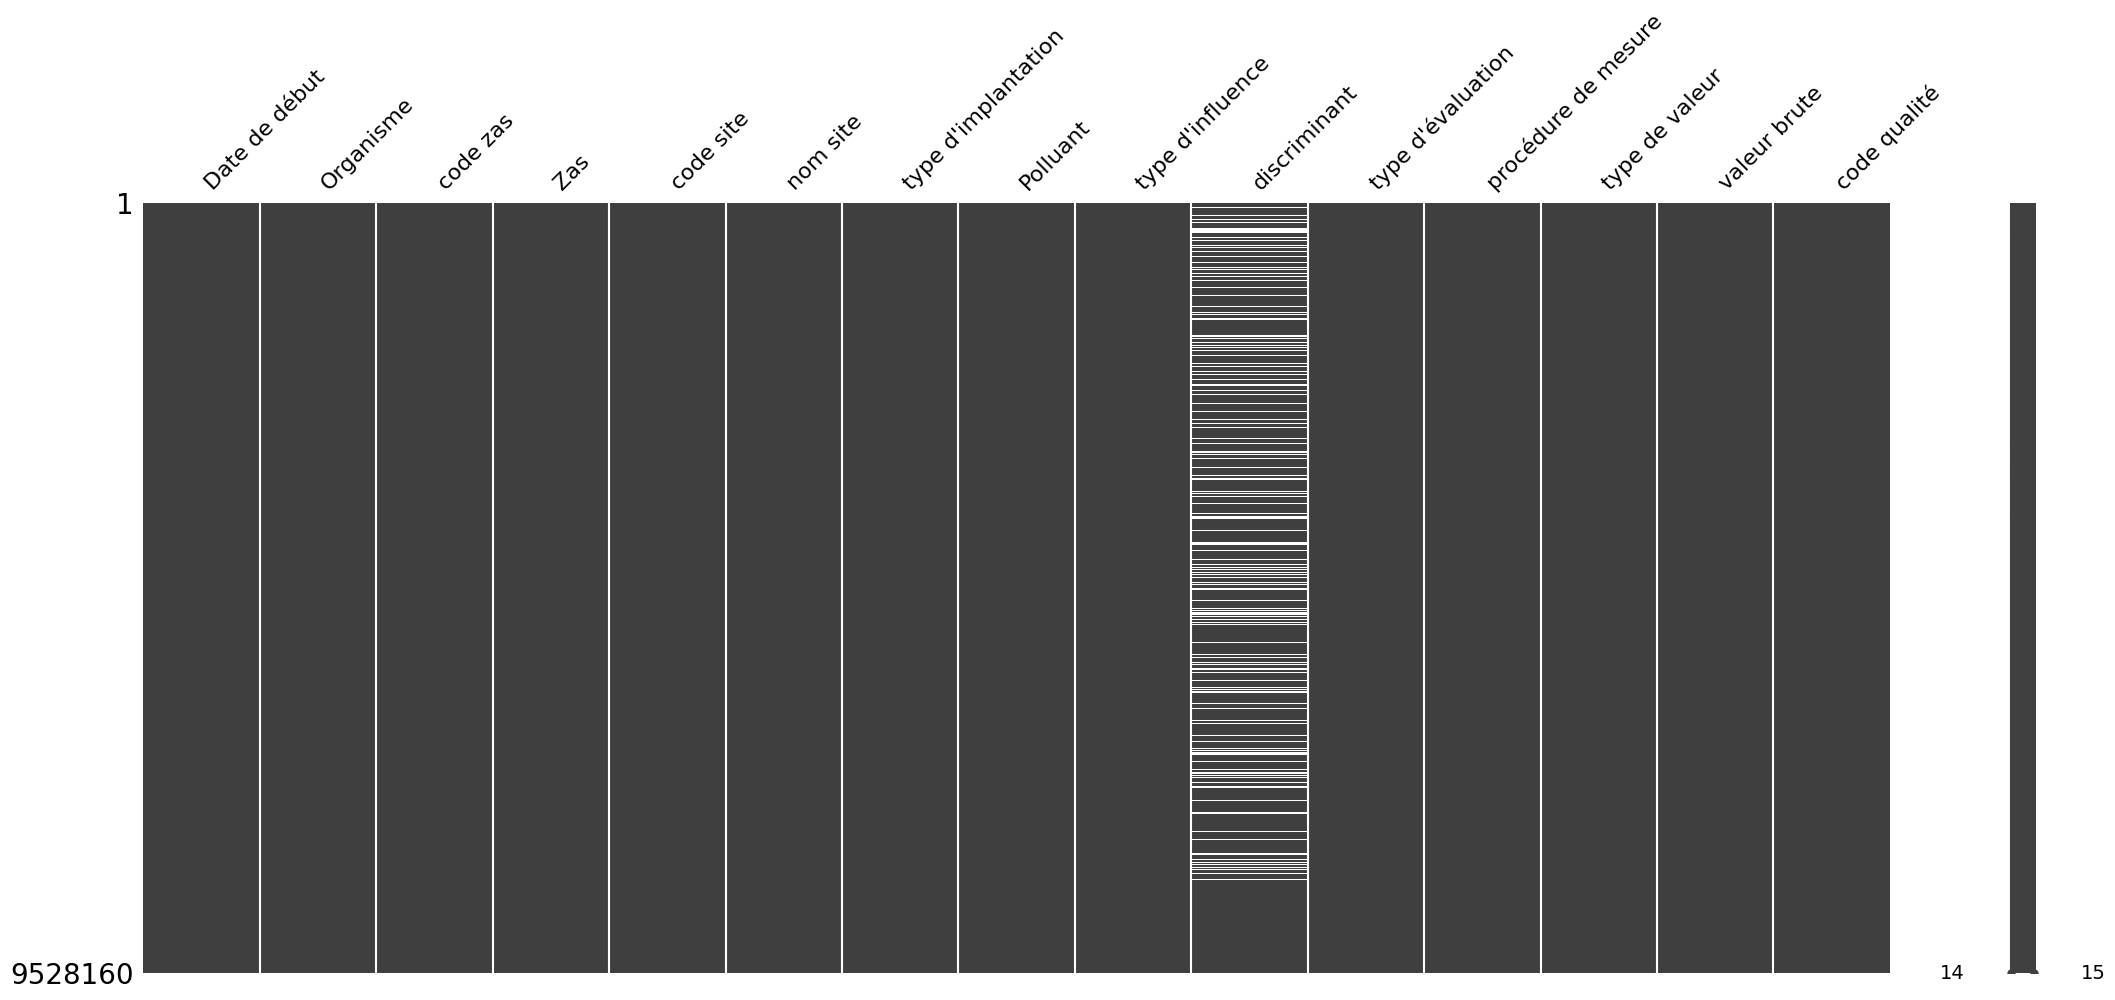

In [84]:
# Matrice des données manquantes avec missingno
msno.matrix(df)

Ne sachant pas encore la pertinence de l'attribut "discriminant", je n'ai pas pris de décision concernant la suppression ou le traitement des valeur manquantes dans cette colonne.

# Gestion des outliers

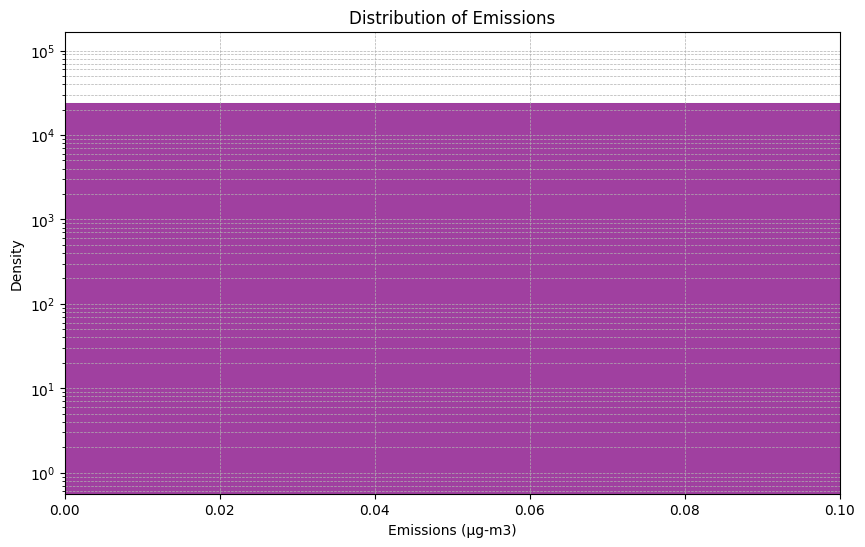

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df["valeur brute"], color="purple")
plt.title("Distribution of Emissions")
plt.xlabel("Emissions (µg-m3)")
plt.ylabel("Density")
plt.xlim(0, 0.1) # set the x-axis limits to 0 and 0.1
plt.yscale('log') # set the y-axis scale to logarithmic
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


On remarque que la distribution des valeurs est homogène. 

C:\Users\chanf\AppData\Local\Temp\ipykernel_20772\1589697135.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, x="nom site", y="valeur brute", palette="viridis")
C:\Users\chanf\AppData\Local\Temp\ipykernel_20772\1589697135.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


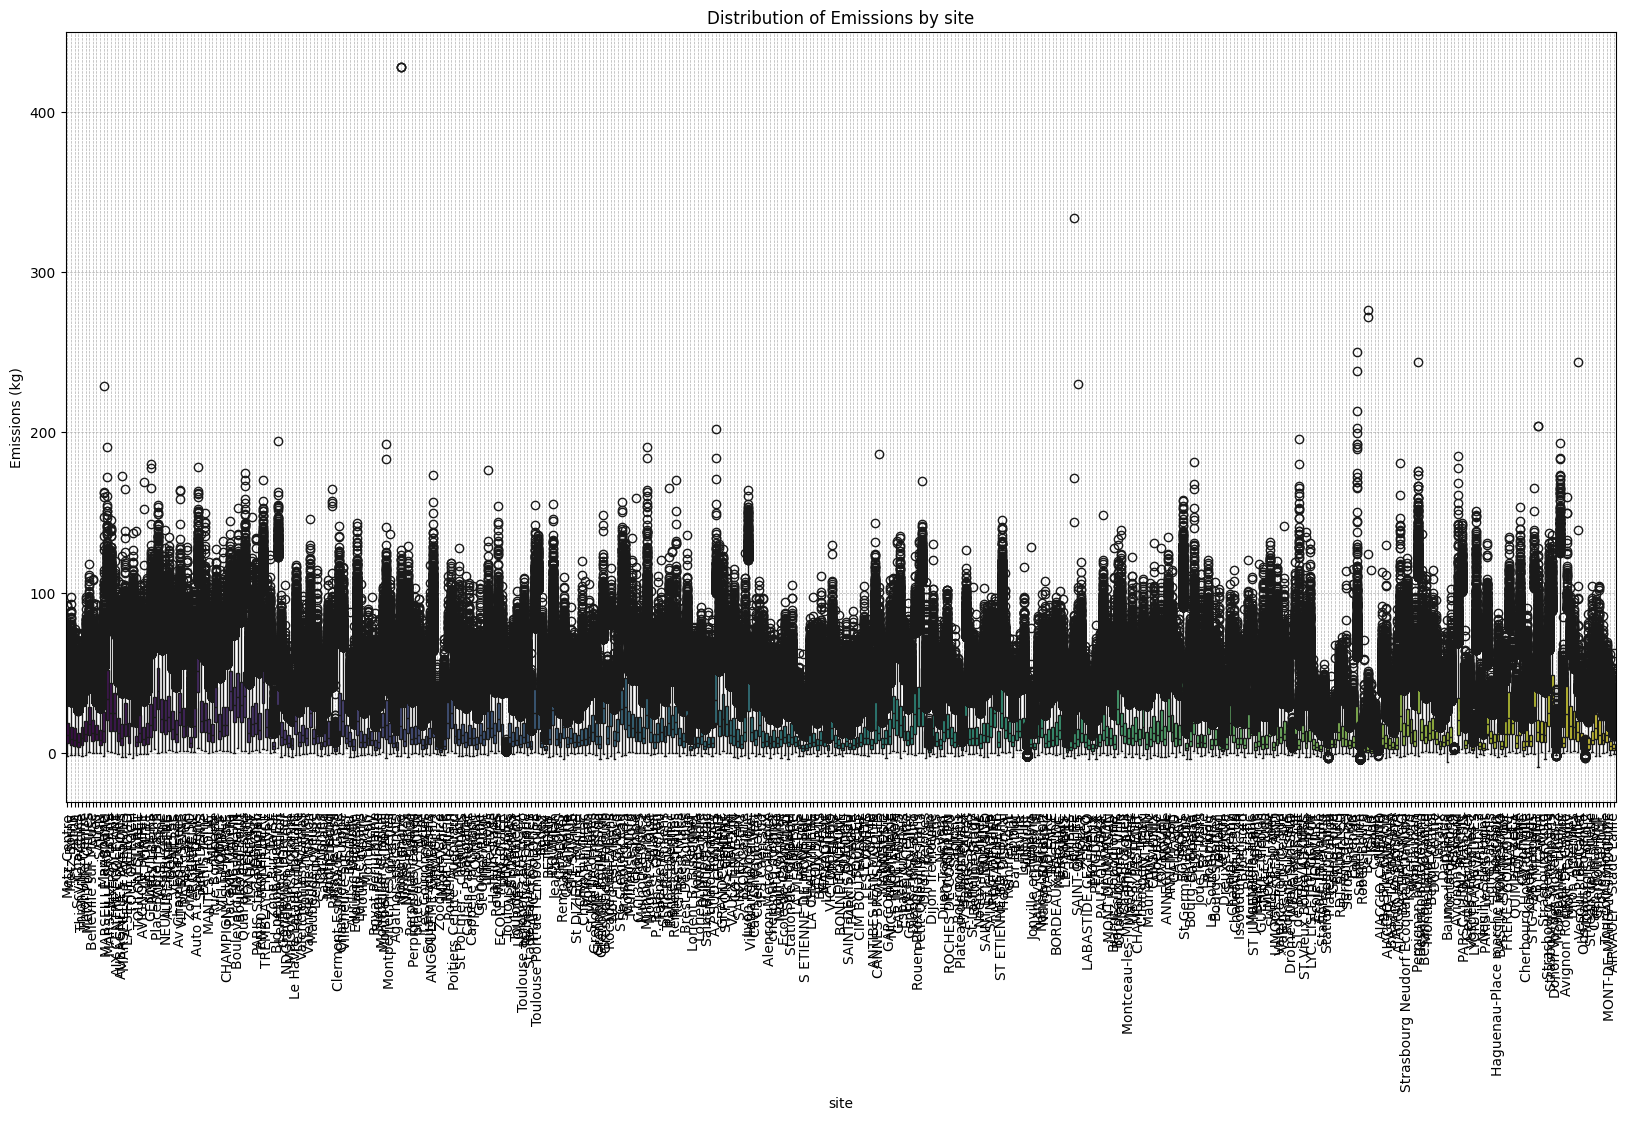

In [91]:
#Boxplots pour la distribution des émissions

# Boxplot de la distribution des émissions par pays
plt.figure(figsize=(20, 10))
ax = sns.boxplot(data=df, x="nom site", y="valeur brute", palette="viridis")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title("Distribution of Emissions by site")
plt.xlabel("site")
plt.ylabel("Emissions (kg)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

On remarque dans le graphique précédent l'apparition de certaines valeurs abérrantes que l'on va supprimer par la méthode des quartiles.

In [94]:
#Gestion des outliers avec la méthode des quartiles de la colonne Emisssions
q1 = df["valeur brute"].quantile(0.25)
q3 = df["valeur brute"].quantile(0.75)
iqr = q3 - q1

# Définir les limites inférieure et supérieure
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Supprimer les outliers
df = df[(df["valeur brute"] > lower_bound) & (df["valeur brute"] < upper_bound)]

df.shape

(8943602, 15)

# Data visualization

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8943602 entries, 0 to 9845036
Data columns (total 15 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Date de début        object 
 1   Organisme            object 
 2   code zas             object 
 3   Zas                  object 
 4   code site            object 
 5   nom site             object 
 6   type d'implantation  object 
 7   Polluant             object 
 8   type d'influence     object 
 9   discriminant         object 
 10  type d'évaluation    object 
 11  procédure de mesure  object 
 12  type de valeur       object 
 13  valeur brute         float64
 14  code qualité         object 
dtypes: float64(1), object(14)
memory usage: 1.1+ GB


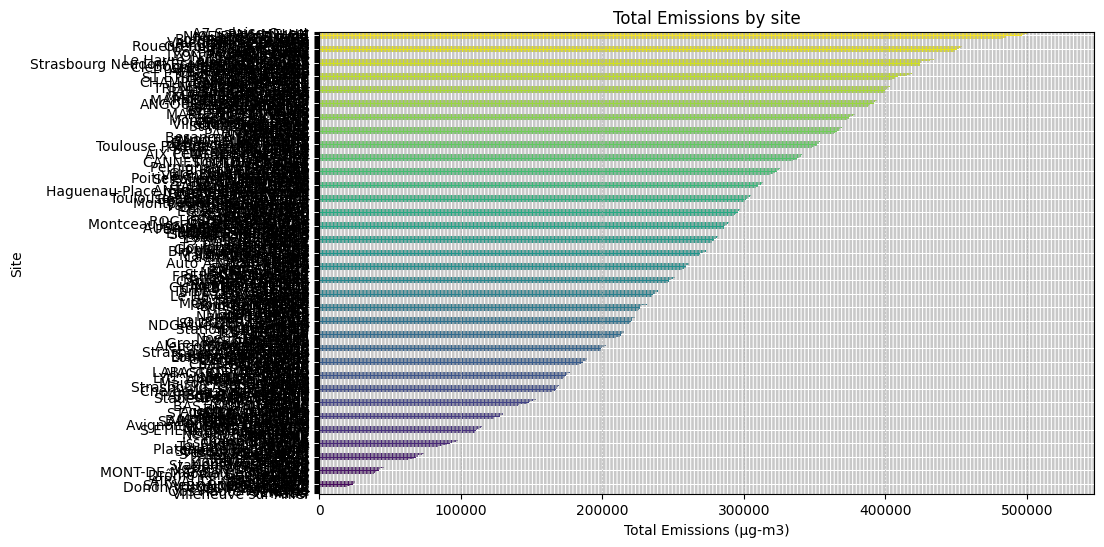

In [101]:
# Bar plot of total emissions by country
emissions_by_site = df.groupby("nom site")["valeur brute"].sum().sort_values()

plt.figure(figsize=(10, 6))
emissions_by_site.plot(kind="barh", color=sns.color_palette("viridis", len(emissions_by_country)))
plt.title("Total Emissions by site")
plt.xlabel("Total Emissions (µg-m3)")
plt.ylabel("Site")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


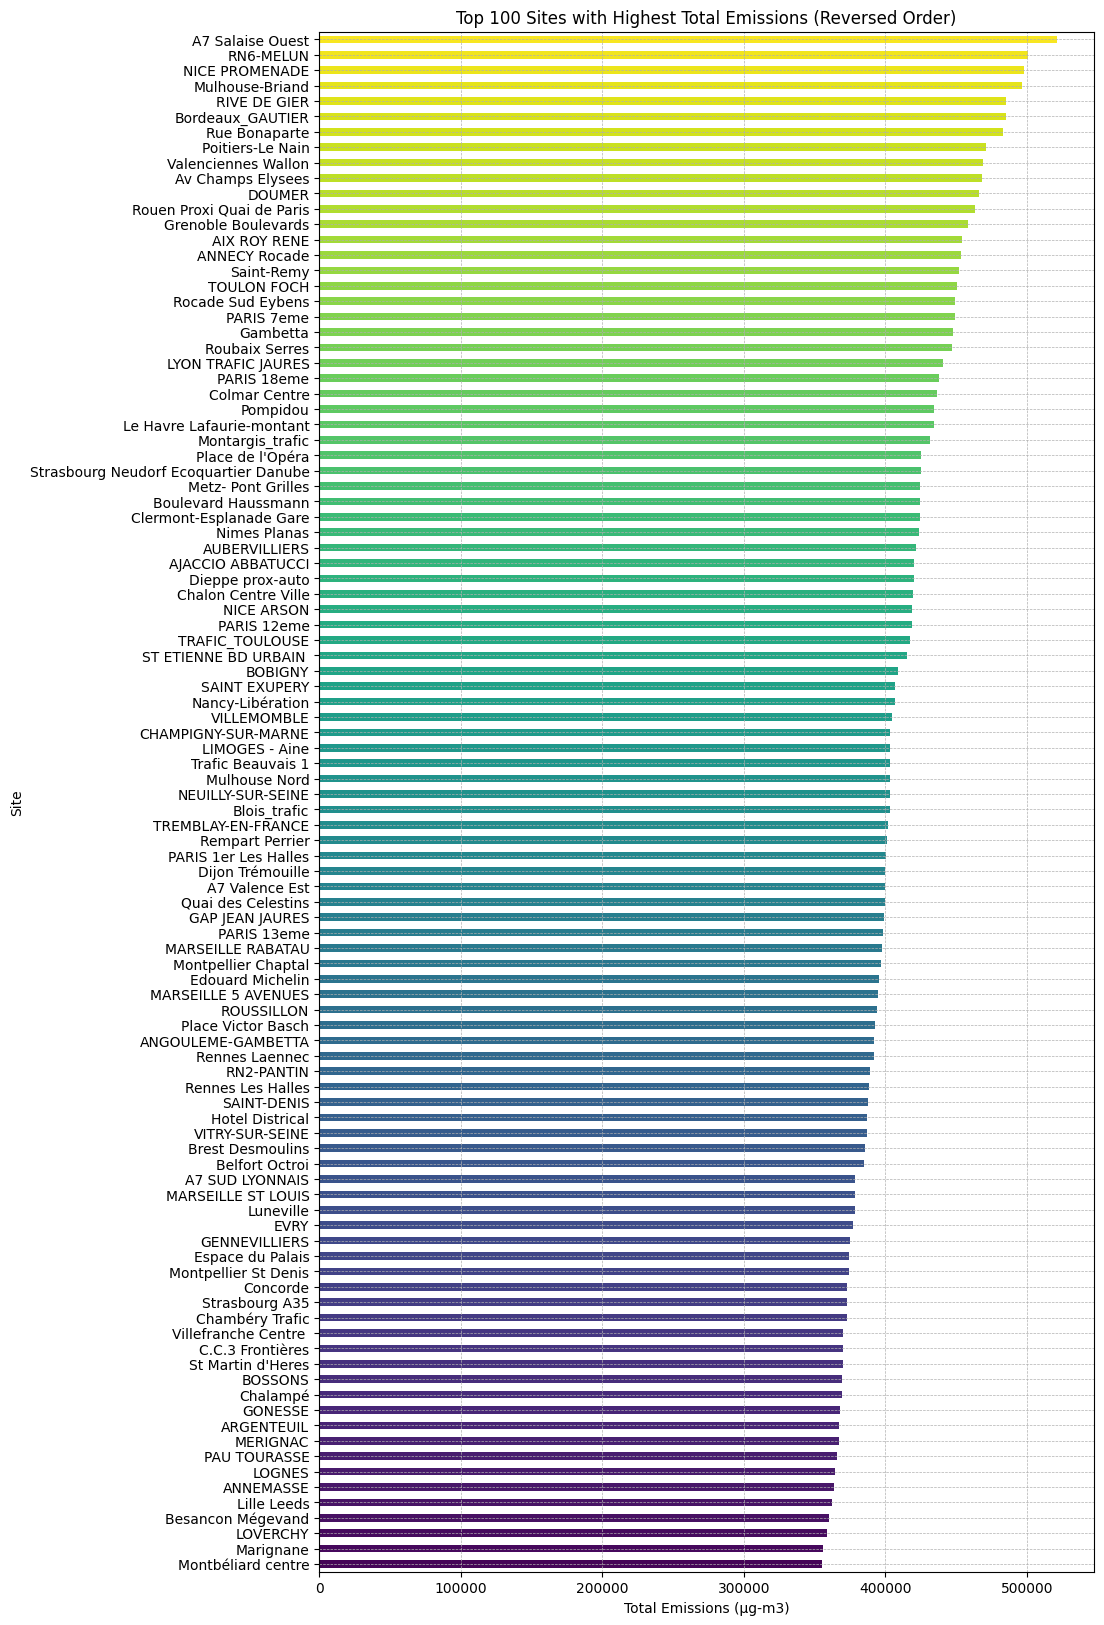

In [108]:
# Bar plot of total emissions by country
emissions_by_site = df.groupby("nom site")["valeur brute"].sum().sort_values(ascending=False).head(100)

plt.figure(figsize=(10, 20))
emissions_by_site[::-1].plot(kind="barh", color=sns.color_palette("viridis", len(emissions_by_country)))
plt.title("Top 100 Sites with Highest Total Emissions (Reversed Order)")
plt.xlabel("Total Emissions (µg-m3)")
plt.ylabel("Site")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


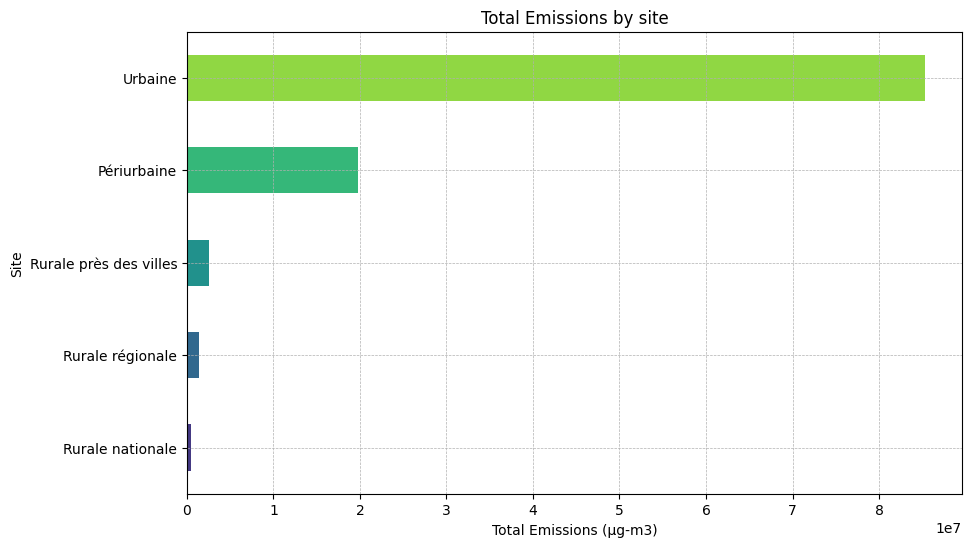

In [102]:
# Bar plot of total emissions by country
emissions_by_site = df.groupby("type d'implantation")["valeur brute"].sum().sort_values()

plt.figure(figsize=(10, 6))
emissions_by_site.plot(kind="barh", color=sns.color_palette("viridis", len(emissions_by_country)))
plt.title("Total Emissions by zone")
plt.xlabel("Total Emissions (µg-m3)")
plt.ylabel("Site")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


Faire un plot pour un affichage par différent site

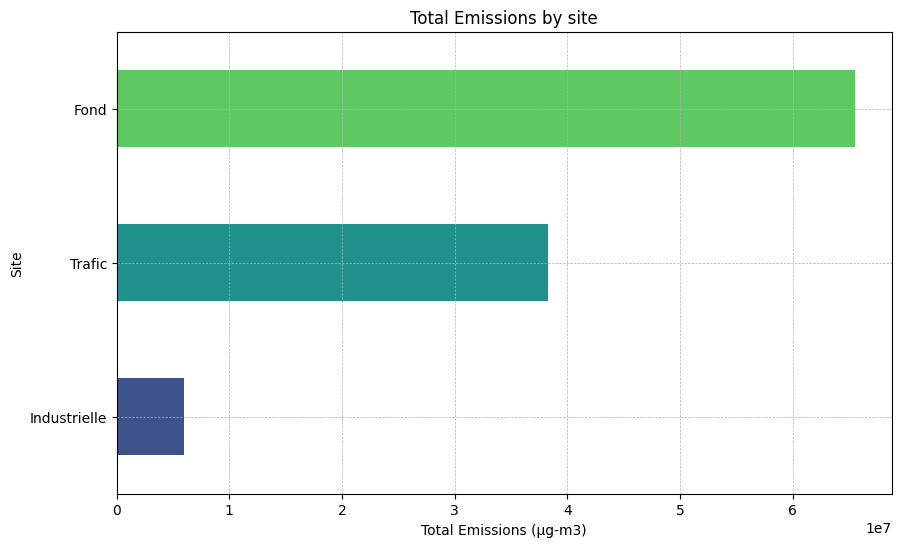

In [103]:
# Bar plot of total emissions by country
emissions_by_site = df.groupby("type d'influence")["valeur brute"].sum().sort_values()

plt.figure(figsize=(10, 6))
emissions_by_site.plot(kind="barh", color=sns.color_palette("viridis", len(emissions_by_country)))
plt.title("Total Emissions by type of influence")
plt.xlabel("Total Emissions (µg-m3)")
plt.ylabel("Site")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


Fond = emissions autres que Trafic et industrielle 

C:\Users\chanf\AppData\Local\Temp\ipykernel_20772\3706809525.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_time, x="Date de début", y="valeur brute", ci=None, marker="o")


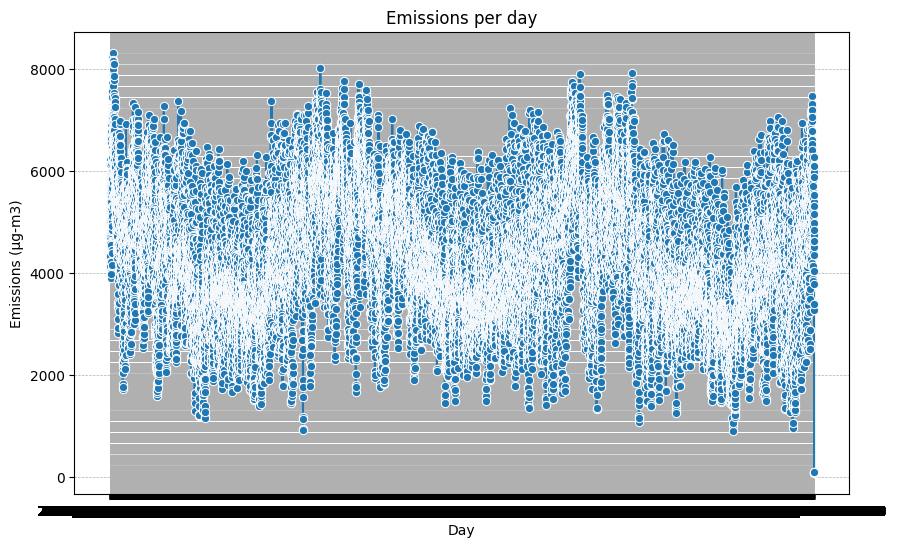

In [115]:
#Graphique de série temporelle pour les émissions par année

# Créer un dataframe avec les émissions par année
df_time = df.groupby("Date de début")["valeur brute"].sum().reset_index()

# Plot de la série temporelle
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_time, x="Date de début", y="valeur brute", ci=None, marker="o")
plt.title("Emissions per day")
plt.xlabel("Day")
plt.ylabel("Emissions (µg-m3)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


affichage des emissions par jour 

C:\Users\chanf\AppData\Local\Temp\ipykernel_20772\2241838623.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["nom_site_aggregated"] = df["nom site"].apply(lambda x: "Other" if x in low_emission_site else x)
C:\Users\chanf\AppData\Local\Temp\ipykernel_20772\2241838623.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x="Date de début", y="valeur brute", hue="nom_site_aggregated", ci=None, marker="o")


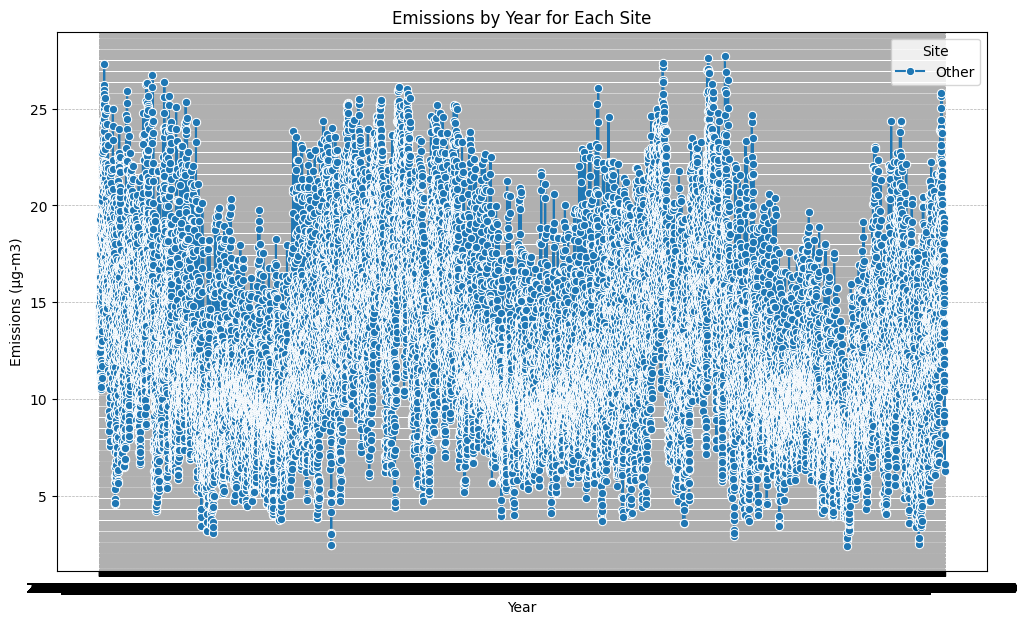

In [114]:
# Define a threshold for low emissions
threshold = df["valeur brute"].sum() * 0.03 # For example, countries with total emissions less than 5% of the overall sum

# Determine countries with total emissions below the threshold
low_emission_site = df.groupby("nom site")["valeur brute"].sum()
low_emission_site = low_emission_site[low_emission_site < threshold].index.tolist()

# Replace names of low emission countries with "Other" in the dataframe
df["nom_site_aggregated"] = df["nom site"].apply(lambda x: "Other" if x in low_emission_site else x)

# Time series plot of emissions by year for each aggregated country
plt.figure(figsize=(12, 7))
sns.lineplot(data=df, x="Date de début", y="valeur brute", hue="nom_site_aggregated", ci=None, marker="o")
plt.title("Emissions by Year for Each Site")
plt.xlabel("Year")
plt.ylabel("Emissions (µg-m3)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend(title="Site")
plt.show()

In [104]:
'''
import geopandas as gpd
import matplotlib.pyplot as plt
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Renommer la colonne contenant les noms des pays
world = world.rename(columns={"name": "nom site"})
world.head()

# Plot de la carte choroplèthe
plt.figure(figsize=(20, 10))
world.boundary.plot(color='black', linewidth=0.5)
df_geo = pd.merge(world, df, on="nom site")
df_geo.plot(column="Emissions", cmap="OrRd", legend=True)
plt.title("Emissions by Site")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()
'''

'\nimport geopandas as gpd\nimport matplotlib.pyplot as plt\nworld = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))\n\n# Renommer la colonne contenant les noms des pays\nworld = world.rename(columns={"name": "nom site"})\nworld.head()\n\n# Plot de la carte choroplèthe\nplt.figure(figsize=(20, 10))\nworld.boundary.plot(color=\'black\', linewidth=0.5)\ndf_geo = pd.merge(world, df, on="nom site")\ndf_geo.plot(column="Emissions", cmap="OrRd", legend=True)\nplt.title("Emissions by Site")\nplt.xlabel("Longitude")\nplt.ylabel("Latitude")\nplt.grid(True, which="both", linestyle="--", linewidth=0.5)\nplt.show()\n'

# Création du dataset de prédiction

In [105]:
start_date = "2023/01/01 06:00:00"
row = df[df['Date de début'] == start_date]
print(row)


               Date de début                     Organisme   code zas  \
6739922  2023/01/01 06:00:00                ATMO GRAND EST  FR44ZAG02   
6739946  2023/01/01 06:00:00                ATMO GRAND EST  FR44ZAG02   
6739970  2023/01/01 06:00:00                ATMO GRAND EST  FR44ZRE01   
6739994  2023/01/01 06:00:00                ATMO GRAND EST  FR44ZAG02   
6740018  2023/01/01 06:00:00                ATMO GRAND EST  FR44ZAG02   
...                      ...                           ...        ...   
6749066  2023/01/01 06:00:00  ATMO BOURGOGNE-FRANCHE-COMTE  FR27ZRE01   
6749090  2023/01/01 06:00:00  ATMO BOURGOGNE-FRANCHE-COMTE  FR27ZRE01   
6749114  2023/01/01 06:00:00  ATMO BOURGOGNE-FRANCHE-COMTE  FR27ZRE01   
6749138  2023/01/01 06:00:00  ATMO BOURGOGNE-FRANCHE-COMTE  FR27ZRE01   
6749162  2023/01/01 06:00:00  ATMO BOURGOGNE-FRANCHE-COMTE  FR27ZRE01   

                                Zas code site             nom site  \
6739922                    ZAG METZ   FR01011        

In [106]:
unique_counts = df.nunique()
print(unique_counts)

Date de début          25627
Organisme                 18
code zas                  82
Zas                       79
code site                421
nom site                 428
type d'implantation        5
Polluant                   1
type d'influence           3
discriminant              10
type d'évaluation          3
procédure de mesure       16
type de valeur             2
valeur brute           24192
code qualité               2
dtype: int64


commencer à réfléchir comment croiser les différents dataset en fonction des différents polluants.